In [ ]:
!pip install --pre deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.5/709.5 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 22.5 MB/s eta 0:00:00


In [ ]:
import deepchem as dc
from deepchem.models.optimizers import Adam, ExponentialDecay
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
#import seaborn as sns
import rdkit, rdkit.Chem, rdkit.Chem.Draw
import tensorflow as tf
import urllib
from collections import Counter
from google.colab import drive 
drive.mount('/content/gdrive')
dataset = pd.read_csv("gdrive/MyDrive/dataset/CSD_EES_DB.csv")  ##maybe implement standardising the data as a transformer?

Mounted at /content/gdrive


In [ ]:
## Removing broken SMILES entries

badboys = []
for i in reversed(range(len(dataset))): ## go backwards through list so indexes don't get messed up during the iteration
  try:
    m = rdkit.Chem.MolFromSmiles(dataset.SMILES[i])
    m = rdkit.Chem.AddHs(m)
    #print(i)
  except: 
    badboys.append(i)
print("there are " + str(len(badboys)) + " evil values:")
print( badboys)

for i in range(len(badboys)):
  n = badboys[i]
  dataset = dataset.drop([dataset.index[n]])  ## remove bad values from dataset
dataset = dataset.reset_index(drop=True)
print("New dataset length = " + str(len(dataset)))

## Certain atoms only occur very rarely in the dataset. To simplify the data for the neural network, any molecule containing the least common atoms should be removed.
allatoms = []
for i in reversed(range(len(dataset))):
  m = rdkit.Chem.MolFromSmiles(dataset.SMILES[i])
  for atom in m.GetAtoms():
    allatoms.append(atom.GetSymbol())

print("total atoms: ", len(allatoms))
Counter(allatoms)

Imolecules = []
Semolecules = []
Asmolecules = []
normalmolecules = []
for i in reversed(range(len(dataset))):
  m = rdkit.Chem.MolFromSmiles(dataset.SMILES[i])
  for atom in m.GetAtoms():
    if atom.GetSymbol() == "I":
      Imolecules.append(dataset.index[i])
    elif atom.GetSymbol() == "Se":
      Semolecules.append(dataset.index[i])
    elif atom.GetSymbol() == "As":
      Asmolecules.append(dataset.index[i])
    else:
      normalmolecules.append(dataset.index[i])

allbadmolecules = Asmolecules + Semolecules + Imolecules
allbadmolecules.sort(reverse=True)

print("instances of I: " + str(len(Imolecules)))
print("instances of Se: " + str(len(Semolecules)))
print("instances of As: " + str(len(Asmolecules)))
print("Atoms that are none of these: " + str(len(normalmolecules)))

print(allbadmolecules)  ## SOME INDEXES APPEAR MORE THAN ONCE IN THIS LIST DUE TO HAVING MORE THAN ONE OF THE UNWANTED ATOMS. TO AVOID PROBLEMS LATER, THE DUPLICATES NEED TO BE REMOVED
print(len(allbadmolecules))

nodupe = []
[nodupe.append(x) for x in allbadmolecules if x not in nodupe]
#print(nodupe) ## these are the indexes of all molecules in the dataset that contain uncommon atoms.
#print(len(nodupe))

for i in range(len(nodupe)):
  n = nodupe[i]
  dataset = dataset.drop([dataset.index[n]])  ## remove bad values from dataset
dataset = dataset.reset_index(drop=True)
print("New dataset length = " + str(len(dataset)))

raw_train_data = dataset.iloc[:38206, :]
raw_val_data = dataset.iloc[38206:42206, :]
raw_test_data = dataset.iloc[42206:, :]

there are 457 evil values:
[47815, 47814, 47813, 47812, 47631, 47589, 47588, 47443, 47442, 47441, 47439, 47438, 47437, 47436, 47434, 47433, 47432, 47366, 47365, 47364, 47347, 47345, 47301, 47300, 47291, 47263, 47249, 47248, 47212, 47210, 47209, 47208, 47195, 47006, 47000, 46999, 46998, 46996, 46995, 46994, 46993, 46992, 46991, 46985, 46984, 46983, 46980, 46926, 46925, 46899, 46896, 46698, 46697, 46103, 45913, 45842, 45813, 45334, 45267, 45084, 45083, 45082, 45015, 45013, 44175, 44137, 44120, 44076, 44060, 44059, 44058, 43980, 43979, 43976, 43948, 43677, 43661, 43654, 43460, 43459, 43458, 42246, 42219, 42121, 42120, 42104, 42070, 42069, 42068, 41852, 41851, 41850, 41849, 41788, 41786, 41785, 41643, 41642, 41614, 41612, 41538, 41536, 41535, 41312, 40406, 40401, 40393, 40392, 40391, 40381, 40322, 40321, 40320, 40318, 40316, 40315, 40314, 40313, 40312, 40231, 40080, 40079, 40040, 40039, 40038, 39835, 39612, 39485, 39484, 37692, 37663, 37657, 37626, 37197, 37168, 37167, 37126, 37093, 37092,

In [ ]:

featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
train_smiles = featurizer.featurize(list(raw_train_data.SMILES))
val_smiles = featurizer.featurize(list(raw_val_data.SMILES))
test_smiles = featurizer.featurize(list(raw_test_data.SMILES))

In [ ]:
train_data = dc.data.NumpyDataset(X=train_smiles, y=raw_train_data.HOMO)
val_data = dc.data.NumpyDataset(X=val_smiles, y=raw_val_data.HOMO)
test_data = dc.data.NumpyDataset(X=test_smiles, y=raw_test_data.HOMO)

In [ ]:

#train_dataset = dc.data.NumpyDataset.from_dataframe(df=raw_train_data, X=['LUMO','E(S1)','f(S1)','E(S2)','f(S2)','E(S3)','f(S3)','E(T1)'],  y='HOMO')

#train_dataset = dc.data.NumpyDataset.from_dataframe(df=raw_train_data, X='SMILES',  y='HOMO')
#val_dataset = dc.data.NumpyDataset.from_dataframe(df=raw_val_data, X='SMILES',  y='HOMO')
#test_dataset = dc.data.NumpyDataset.from_dataframe(df=raw_test_data, X='SMILES',  y='HOMO')



In [ ]:
model = dc.models.GraphConvModel(1, mode='regression')
model.fit(train_data, nb_epoch = 15)

0.08316649330986871

In [ ]:
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
print("train: ", model.evaluate(train_data, [metric]))
print("test: ", model.evaluate(test_data, [metric]))


train:  {'mean_squared_error': 0.08039361831179233}
test:  {'mean_squared_error': 0.40020812619863533}


correlation coefficient:  0.718581244104755


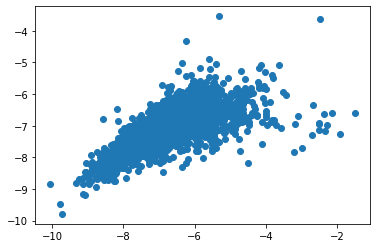

In [ ]:
y_meas = test_data.y
y_pred = (model.predict(test_data)).flatten()

#plt.xlim([2.5, 10.5])
#plt.ylim([-10.1, -3])
plt.scatter(y_meas, y_pred)

corr = np.corrcoef(y_meas, y_pred)[0, 1]
print("correlation coefficient: ", corr)